### Demo of Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 16*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-12 12:57:48.089099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 12:57:48.184185: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-12 12:57:48.583286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-12 12:57:48.583340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-12 12:57:49.154694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 12:57:49.154953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 12:57:49.155098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 12:57:49.514754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 12:57:49.514933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [3]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #10
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [4]:
idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

pc1 = np.load(fn1)

#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(gt[idx, 2:])

offset = 0#for debug 
rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# print(rot_m)

initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# pc1 = pc1 @ rot_m
# rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# pc1 = pc1 @ rotcorr
# pc1 += initial_guess[:3]

In [5]:
# # len(gt)
# # # ans = gt[:,0] - gt[0,0]
# # # ans = np.where(np.diff(gt[:,0]) > 0.99 )
# # # # print(ans)

# from matplotlib import pyplot as plt
# fig, ax = plt.subplots()

# t = gt[:,0] + gt[:,1]/(1e9)
# # ax.plot(np.diff(t)) #pretty interesting results for  dynamic spinning dataset
# # ax.set_title("06- Dynamic Spinning Frame Length")
# # print(np.mean(np.diff(t[100:1100])))

# ax.plot(np.diff(gt[:,2]))
# len(gt)

In [79]:
# Get Ground Truth Poses via code shamelessly taken from KitWare pyLiDAR-SLAM library

#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses) #try commenting out

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [83]:
idx = 2850 #2650 #2000 - 3000 is the running and swinging loop
skip = 5 #how many lidar frames between clouds
# (need to deal with how there are more LIDAR frames than ground truth poses)
offset = 11 #10 #11  #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 950 #1080 #950 #fast motion
# # idx = 116 #slow distortion, very accurate solution
# skip = 1 #how many lidar frames between clouds
# offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#COLOR SCAN1 POINTS BY ORDER IN CLOUD
color = 255*np.linspace(0,1,len(scan1_lidarframe))
cname = np.array([255-color//2, color, 255-color]).T.tolist()
disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))

# # DRAW SCANS 1, 2
# disp.append(Points(scan1_lidarframe, c = '#a65852', r = 3)) #red
# disp.append(Points(scan2_lidarframe, c = '#2c7c94', r = 3)) #blue

disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314
plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Run 12-State ICET

In [84]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 0.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 100, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

#scan to scan
# dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 50, niter = 10, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = 2.5, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([449   3   3], shape=(3,), dtype=int32)

 residuals (1347, 1)

 delta_A
 (12,)
A: 
 [-0.0277 -0.0473 -0.0023  0.0048  0.0063  0.0009] 
 [-0.026   0.051   0.0554  0.0048  0.0044 -0.001 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([442   3   3], shape=(3,), dtype=int32)

 residuals (1326, 1)

 delta_A
 (12,)
A: 
 [-0.0081 -0.0828 -0.0202  0.0056  0.0055  0.0027] 
 [-0.0553  0.0827  0.1071  0.0088  0.0077 -0.0026]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([444   3   3], shape=(3,), dtype=int32)

 residuals (1332, 1)

 delta_A
 (12,)
A: 
 [ 0.0156 -0.1059 -0.0298  0.0049  0.0042  0.0039] 
 [-0.0823  0.1102  0.1346  0.0118  0.0097 -0.0044]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([444   3   3], shape=(3,), dtype=int32)

 residuals (1332, 1)

 delta_A
 (12,)
A: 
 [ 0.0393 -0.1221 -0.0326  0.0044  0.0034  0.0049] 
 [-0.1161  0.1369  0.146   0.0136  0.0108 -0.0061]
~~~~~~~~~~~Iterat

A: 
 [ 0.1307 -0.1719 -0.0231  0.0016  0.0031  0.0034] 
 [-0.382   0.2519  0.139   0.017   0.0114  0.0046]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1422 -0.1723 -0.024   0.0019  0.0033  0.0036] 
 [-0.3908  0.2521  0.1392  0.0168  0.0111  0.0041]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1383 -0.1729 -0.0248  0.0019  0.003   0.0034] 
 [-0.3941  0.2584  0.1426  0.0169  0.0117  0.0045]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1425 -0.1719 -0.0258  0.0021  0.003   0.0035] 
 [-0.4022  0.2524  0.1418  0.0166  0.0114  0.0039]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([446   3   3], shape=(3,), dtype=int32)

 residuals (1338, 1)

 delta_A
 (12,)
A: 
 [ 0.1308 -0.165  -0.0253  0.0021  0.0031  0.0029] 


LUT tf.Tensor([444   3   3], shape=(3,), dtype=int32)

 residuals (1332, 1)

 delta_A
 (12,)
A: 
 [ 0.1171 -0.1494 -0.0219  0.0015  0.0031  0.0014] 
 [-0.2957  0.2345  0.1367  0.0173  0.0112  0.0059]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1143 -0.1478 -0.0223  0.0014  0.0031  0.0013] 
 [-0.3029  0.2265  0.1375  0.0175  0.0112  0.0055]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1172 -0.1499 -0.0218  0.0014  0.003   0.0019] 
 [-0.2952  0.2345  0.1375  0.0175  0.0113  0.0051]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.1112 -0.148  -0.0224  0.0015  0.0029  0.0017] 
 [-0.2912  0.2296  0.1376  0.0173  0.0115  0.0049]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [85]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #transformed scan

#need to downsample to keep runtime down
target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] 

dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(dc.cloud2_tensor))

Chamfer Distance OG: 
: 37322.953125
Chamfer Distance after transform: 
: 23061.3828125

 Normalized OG CD: 
 tensor(0.7148)

 Normalized transformed CD: 
 tensor(0.4417)


# Calculate Chamfer Distance over 100 frame sequence in Dynamic Spinning Trajectory

In [76]:
runlen = 10 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 1. #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
        dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 100, 
                draw = False, mnp = 25, RM = False, solver = '12_state', 
                max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 25, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
    source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
    source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #need to downsample to keep runtime down
    target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    


 
 Frame # 950 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.118  -0.2195  0.1413  0.0294 -0.0187 -0.011 ] 
 [-0.0715  0.5455  0.1314  0.0175  0.0069  0.0679]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.0288 -0.2214  0.1433  0.0159 -0.0402 -0.0262] 
 [0.0134 0.5498 0.3239 0.0865 0.0375 0.1192]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.0597 -0.0539  0.0464  0.0099 -0.0448 -0.0536] 
 [0.037  0.1268 0.4981 0.1174 0.0323 0.1754]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [ 0.0361  0.1037  0.0308  0.005  -0.0387 -0.0713] 
 [ 0.0227 -0.2296  0.4851  0.1306  0.0134  0.2224]
~~~~~~~~~~~It

LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.1308  0.0073  0.1677 -0.0118 -0.0362 -0.0663] 
 [ 0.088  -0.2635 -0.0808  0.1638  0.0344  0.2352]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.1291 -0.0042  0.1702 -0.0118 -0.0362 -0.0655] 
 [ 0.0871 -0.2427 -0.0874  0.163   0.0348  0.234 ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.1317 -0.0128  0.171  -0.0109 -0.0356 -0.0657] 
 [ 0.0888 -0.2297 -0.0988  0.1603  0.0348  0.2346]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.1301 -0.0154  0.1653 -0.0109 -0.0358 -0.0649] 
 [ 0.0876 -0.2299 -0.0879  0.1609  0.0344  0.233 ]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.1445 -0.1918  0.0873 -0.0047 -0.0428 -0.0467] 
 [0.0936 0.0095 0.039  0.1531 0.0394 0.2088]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.1429 -0.1932  0.0908 -0.0043 -0.0426 -0.0455] 
 [0.0929 0.0144 0.0259 0.1514 0.0395 0.2076]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 0.1471 -0.2034  0.0918 -0.0035 -0.0425 -0.0462] 
 [0.0952 0.0257 0.02   0.1502 0.0395 0.2083]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.1502 -0.2041  0.0865 -0.0035 -0.0424 -0.0459] 
 [0.097  0.022  0.0253 0.15   0.0394 0.208 ]
~~~~~~~~~~~Iteration  75 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A

LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.319   0.4339 -0.0899 -0.0404  0.0182 -0.0847] 
 [ 0.1744 -1.1188  0.2857  0.0785 -0.084   0.3253]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3237  0.4141  0.0136 -0.0333  0.0228 -0.0789] 
 [ 0.1792 -1.0634  0.0877  0.0612 -0.075   0.3328]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.3258  0.4144  0.0837 -0.0265  0.0259 -0.0725] 
 [ 0.1835 -1.0575 -0.0983  0.0443 -0.0706  0.3287]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0273  0.4213  0.1216 -0.0217  0.0254 -0.0633] 
 [ 0.0166 -1.0539 -0.2096  0.0359 -0.0663  0.317 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0885  0.2833  0.2052  0.0045 -0.0287  0.0106] 
 [ 0.0654 -0.6447 -0.0807  0.0543  0.031   0.2382]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0885  0.2819  0.2045  0.005  -0.029   0.0108] 
 [ 0.0654 -0.6452 -0.0788  0.0543  0.032   0.2382]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0884  0.275   0.2085  0.0052 -0.0291  0.0122] 
 [ 0.0657 -0.629  -0.0926  0.0533  0.0332  0.236 ]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0886  0.2735  0.2063  0.0055 -0.0302  0.0125] 
 [ 0.0657 -0.6294 -0.0852  0.0538  0.0352  0.2355]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.0941  0.1513  0.1371 -0.0025 -0.0329  0.0016] 
 [ 0.0613 -0.4635 -0.001   0.0689  0.0462  0.2464]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.0944  0.1408  0.1433 -0.003  -0.0329  0.0017] 
 [ 0.0614 -0.4413  0.0061  0.0706  0.0464  0.2474]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.094   0.1324  0.1492 -0.0033 -0.0327  0.0015] 
 [ 0.0616 -0.4271 -0.0034  0.0707  0.0464  0.2477]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.0943  0.1277  0.1464 -0.0034 -0.0329  0.0023] 
 [ 0.0616 -0.4179  0.0023  0.071   0.0472  0.2459]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.2419  0.6045  0.2028 -0.0388  0.0417 -0.0707] 
 [ 0.1383 -1.0512 -0.4005  0.0309 -0.1182  0.2988]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.2425  0.6096  0.2171 -0.0359  0.0489 -0.0704] 
 [ 0.1391 -1.0637 -0.4487  0.0263 -0.1299  0.2986]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.2437  0.6172  0.2393 -0.0325  0.0576 -0.0717] 
 [ 0.1407 -1.0886 -0.5335  0.0176 -0.1417  0.3011]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.2458  0.6225  0.2697 -0.0302  0.0703 -0.0693] 
 [ 0.1434 -1.0919 -0.6505  0.0082 -0.1574  0.2993]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [-0.5707  0.3354  0.0503  0.0005  0.1285 -0.1404] 
 [-0.3243 -0.6386  1.0913  0.0672 -0.1627  0.3871]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [-0.5745  0.4323  0.1097 -0.0002  0.1282 -0.1182] 
 [-0.3247 -0.7177  0.9663  0.0626 -0.164   0.3595]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [-0.5779  0.4133  0.1415  0.0046  0.1282 -0.1172] 
 [-0.3253 -0.698   0.9199  0.0563 -0.1633  0.3526]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [-0.5836  0.4447  0.1883  0.0058  0.1299 -0.1164] 
 [-0.3257 -0.7549  0.8512  0.0538 -0.1651  0.3507]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.3568  0.7199  0.1966 -0.0592  0.1091 -0.0943] 
 [-0.1511 -1.2499 -0.3748  0.0655 -0.2212  0.329 ]
~~~~~~~~~~~Iteration  84 ~~~~~~~~~~
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.3578  0.7091  0.1759 -0.0608  0.0965 -0.0993] 
 [-0.1526 -1.2496 -0.292   0.076  -0.2077  0.3339]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.3559  0.7183  0.1556 -0.0611  0.0858 -0.0972] 
 [-0.1546 -1.2575 -0.2391  0.0787 -0.1912  0.332 ]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [ 0.3614  0.7262  0.1959 -0.0596  0.1063 -0.0916] 
 [-0.1492 -1.2493 -0.3779  0.0661 -0.2156  0.3274]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([186   3   3], shape=(3,), dtype=int32)

 residuals (558, 1)

 delta_A
 (12,)
A: 
 [ 0.3951 -0.0032 -0.1146 -0.1443 -0.0279 -0.1423] 
 [ 0.2095 -0.135  -0.1241  0.1696  0.0533  0.4233]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([185   3   3], shape=(3,), dtype=int32)

 residuals (555, 1)

 delta_A
 (12,)
A: 
 [ 0.397  -0.01   -0.1137 -0.1443 -0.0266 -0.1447] 
 [ 0.2111 -0.129  -0.1311  0.1689  0.0525  0.4272]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([185   3   3], shape=(3,), dtype=int32)

 residuals (555, 1)

 delta_A
 (12,)
A: 
 [ 0.401  -0.0166 -0.1208 -0.1429 -0.0245 -0.148 ] 
 [ 0.2145 -0.1246 -0.1382  0.1652  0.051   0.4324]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([186   3   3], shape=(3,), dtype=int32)

 residuals (558, 1)

 delta_A
 (12,)
A: 
 [ 0.4057 -0.0199 -0.138  -0.1426 -0.0235 -0.1515] 
 [ 0.2182 -0.1283 -0.1094  0.1654  0.0474  0.4373]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([187   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([162   3   3], shape=(3,), dtype=int32)

 residuals (486, 1)

 delta_A
 (12,)
A: 
 [ 2.3101 -1.2375 -1.2668 -0.3476 -0.0564 -0.5905] 
 [ 1.8087  0.6779 -0.1205  0.294   0.4273  0.8367]
~~~~~~~~~~~Iteration  54 ~~~~~~~~~~
LUT tf.Tensor([160   3   3], shape=(3,), dtype=int32)

 residuals (480, 1)

 delta_A
 (12,)
A: 
 [ 2.3827 -1.1639 -1.2743 -0.3536 -0.0441 -0.6363] 
 [ 1.876   0.4199 -0.3817  0.226   0.4125  0.8578]
~~~~~~~~~~~Iteration  55 ~~~~~~~~~~
LUT tf.Tensor([148   3   3], shape=(3,), dtype=int32)

 residuals (444, 1)

 delta_A
 (12,)
A: 
 [ 2.4312 -1.0653 -1.4124 -0.3593 -0.0187 -0.6739] 
 [ 1.9113  0.1809 -0.1795  0.1962  0.3625  0.8504]
~~~~~~~~~~~Iteration  56 ~~~~~~~~~~
LUT tf.Tensor([150   3   3], shape=(3,), dtype=int32)

 residuals (450, 1)

 delta_A
 (12,)
A: 
 [ 2.4463 -0.8448 -1.4717 -0.3675  0.0422 -0.68  ] 
 [ 1.9213 -0.1669  0.0943  0.2002  0.2374  0.8004]
~~~~~~~~~~~Iteration  57 ~~~~~~~~~~
LUT tf.Tensor([148   3   3], shape=(3,), dtype=int32)

 resi

A: 
 [ 1.9557 -0.238  -1.1106 -0.5074  0.2984 -0.8686] 
 [ 1.6425 -2.0006 -1.0088  0.4755  0.0135  1.0571]
~~~~~~~~~~~Iteration  90 ~~~~~~~~~~
LUT tf.Tensor([152   3   3], shape=(3,), dtype=int32)

 residuals (456, 1)

 delta_A
 (12,)
A: 
 [ 1.9715 -0.2396 -1.1615 -0.5104  0.3103 -0.8834] 
 [ 1.6529 -2.0203 -1.0574  0.4741  0.0028  1.0639]
~~~~~~~~~~~Iteration  91 ~~~~~~~~~~
LUT tf.Tensor([146   3   3], shape=(3,), dtype=int32)

 residuals (438, 1)

 delta_A
 (12,)
A: 
 [ 1.9718 -0.2393 -1.1855 -0.5144  0.3211 -0.8935] 
 [ 1.6528 -2.0033 -1.0814  0.4755  0.002   1.0659]
~~~~~~~~~~~Iteration  92 ~~~~~~~~~~
LUT tf.Tensor([145   3   3], shape=(3,), dtype=int32)

 residuals (435, 1)

 delta_A
 (12,)
A: 
 [ 1.9699 -0.2719 -1.2356 -0.5224  0.3205 -0.9086] 
 [ 1.6521 -1.9546 -0.9728  0.4998  0.0156  1.0727]
~~~~~~~~~~~Iteration  93 ~~~~~~~~~~
LUT tf.Tensor([146   3   3], shape=(3,), dtype=int32)

 residuals (438, 1)

 delta_A
 (12,)
A: 
 [ 1.6574 -0.2604 -1.2166 -0.5269  0.337  -0.9139] 
 [ 1

LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 1.6686  0.4886 -0.9806 -0.0387 -0.0426  0.015 ] 
 [-1.976  -0.8523  1.1489  0.0478 -0.0671  0.1724]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 1.6723  0.4872 -0.9948 -0.037  -0.036   0.0141] 
 [-1.9732 -0.8538  1.1712  0.0449 -0.0759  0.174 ]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 1.6764  0.4852 -0.9922 -0.0354 -0.0331  0.0151] 
 [-1.9693 -0.8494  1.1372  0.0398 -0.0783  0.1726]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 1.6711  0.4849 -0.9897 -0.0368 -0.041   0.0162] 
 [-1.9738 -0.8489  1.1451  0.0452 -0.0683  0.171 ]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 1.6907  0.4357 -1.0056 -0.0356 -0.0345  0.0143] 
 [-1.9542 -0.7773  1.1482  0.0423 -0.0757  0.1744]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 1.6873  0.437  -0.9927 -0.0364 -0.0359  0.0166] 
 [-1.9568 -0.7753  1.1152  0.0431 -0.0744  0.1715]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 1.6839  0.4326 -0.989  -0.0373 -0.0425  0.0183] 
 [-1.9593 -0.7614  1.1317  0.0471 -0.0659  0.1688]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 1.6893  0.4292 -0.9919 -0.0358 -0.0367  0.0177] 
 [-1.9547 -0.7564  1.1372  0.0434 -0.0742  0.1694]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 1.7063  0.3823 -1.0125 -0.0341 -0.0318  0.0172] 
 [-1.939  -0.7014  1.1237  0.041  -0.0795  0.1718]
~~~~~~~~~~~Iteration  96 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 1.6985  0.3858 -1.0161 -0.0344 -0.0329  0.0193] 
 [-1.9458 -0.7039  1.1347  0.0436 -0.0785  0.1703]
~~~~~~~~~~~Iteration  97 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 1.7006  0.3797 -1.0153 -0.0322 -0.0328  0.0208] 
 [-1.9436 -0.6887  1.132   0.0394 -0.0775  0.1677]
~~~~~~~~~~~Iteration  98 ~~~~~~~~~~
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 residuals (675, 1)

 delta_A
 (12,)
A: 
 [ 1.7048  0.3754 -1.0106 -0.0315 -0.0311  0.0211] 
 [-1.9397 -0.6821  1.1195  0.0379 -0.0808  0.1666]
~~~~~~~~~~~Iteration  99 ~~~~~~~~~~
LUT tf.Tensor([224   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6605  0.2943 -0.3656 -0.0692 -0.0473  0.0056] 
 [-0.8543 -0.4758  0.2379  0.0585 -0.1088  0.1017]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6632  0.2889 -0.366  -0.0691 -0.0469  0.0054] 
 [-0.8514 -0.4664  0.2373  0.0588 -0.1098  0.1019]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6646  0.2843 -0.3674 -0.0692 -0.0471  0.0056] 
 [-0.8496 -0.4573  0.2401  0.0596 -0.1097  0.1017]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6657  0.2804 -0.3729 -0.0694 -0.0472  0.006 ] 
 [-0.8483 -0.4512  0.2529  0.061  -0.11    0.1012]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6934  0.1725 -0.366  -0.0688 -0.0492  0.0089] 
 [-0.8104 -0.2593  0.2152  0.0627 -0.108   0.0974]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6937  0.1706 -0.374  -0.0695 -0.0497  0.0087] 
 [-0.8103 -0.26    0.2393  0.0654 -0.1078  0.0976]
~~~~~~~~~~~Iteration  67 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6936  0.1703 -0.3745 -0.0705 -0.05    0.0081] 
 [-0.8104 -0.2629  0.2482  0.0681 -0.1082  0.0988]
~~~~~~~~~~~Iteration  68 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.6952  0.1687 -0.3705 -0.0709 -0.0492  0.0083] 
 [-0.8088 -0.2613  0.2384  0.0679 -0.1093  0.0983]
~~~~~~~~~~~Iteration  69 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 resi

iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24

 estimated solution vector X: 
 tf.Tensor([ 0.2644123   0.26822567 -0.28842387 -0.04452341 -0.10823303  0.0111783 ], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 36862.390625
Chamfer Distance after VICET: 
: 13919.15625
Chamfer Distance after ICET: 
: 20017.1015625

 Normalized OG CD: 
 tensor(0.7256)

 Normalized VICET CD: 
 tensor(0.2740)

 Normalized ICET CD: 
 tensor(0.3940)

 
 Frame # 956 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.6548 -0.0669 -0.3941 -0.0299 -0.041   0.0074] 
 [-1.0059  0.1414  0.16   -0.0344 -0.0481 -0.0066]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [ 0.6624 -0.0


 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.1556 -0.0876  0.0177 -0.0955 -0.0451  0.0354] 
 [ 0.0586  0.1922 -0.2466  0.0432 -0.1957 -0.0586]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1501 -0.0943  0.017  -0.095  -0.0443  0.0356] 
 [ 0.0631  0.2018 -0.2446  0.0416 -0.199  -0.0612]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.1415 -0.1003  0.0184 -0.0952 -0.0448  0.0371] 
 [ 0.0702  0.2071 -0.2466  0.0418 -0.1985 -0.0661]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1475 -0.1029  0.0186 -0.0946 -0.0441  0.0401] 
 [ 0.0654  0.221  -0.2556  0.0396 -0.2003 -0.0698]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.1373 -0.1157 

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0621 -0.1948  0.0102 -0.0824 -0.0376  0.0622] 
 [ 0.1335 -0.2873 -0.2175 -0.0286 -0.2402 -0.3013]
~~~~~~~~~~~Iteration  70 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0106 -0.1845  0.0212 -0.0813 -0.0361  0.0645] 
 [ 0.1942 -0.3598 -0.2221 -0.0369 -0.2455 -0.3205]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [ 0.069  -0.176   0.0056 -0.0807 -0.0364  0.0647] 
 [ 0.2412 -0.4347 -0.2202 -0.0409 -0.248  -0.3344]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.1295 -0.1626 -0.0053 -0.0804 -0.0368  0.0655] 
 [ 0.2897 -0.515  -0.2254 -0.0446 -0.25   -0.3485]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([348   3   3], shape=(3,), dtype=int32)

 residuals (1044, 1)

 delta_A
 (12,)
A: 
 [-0.151  -0.376   0.0239 -0.0539  0.013   0.0252] 
 [ 0.2542  1.0538 -0.983  -0.152  -0.1512 -0.0815]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([347   3   3], shape=(3,), dtype=int32)

 residuals (1041, 1)

 delta_A
 (12,)
A: 
 [-0.4601 -0.3725  0.0976 -0.0591  0.0199  0.0232] 
 [ 0.608   1.1022 -1.0953 -0.1486 -0.1644 -0.0808]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([344   3   3], shape=(3,), dtype=int32)

 residuals (1032, 1)

 delta_A
 (12,)
A: 
 [-0.7292 -0.3665  0.142  -0.0623  0.0233  0.0201] 
 [ 0.9296  1.1411 -1.1612 -0.1446 -0.1703 -0.0801]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([342   3   3], shape=(3,), dtype=int32)

 residuals (1026, 1)

 delta_A
 (12,)
A: 
 [-0.7337 -0.3529  0.1643 -0.0648  0.0233  0.0158] 
 [ 0.9219  1.1525 -1.1875 -0.1376 -0.1692 -0.0773]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([343   3   3], shape=(3,), dtype=int32)

 resi


 residuals (1023, 1)

 delta_A
 (12,)
A: 
 [-0.7662 -0.403   0.1666 -0.0688  0.0209 -0.0036] 
 [ 0.8955  1.1166 -1.1575 -0.1253 -0.1676 -0.0611]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
LUT tf.Tensor([341   3   3], shape=(3,), dtype=int32)

 residuals (1023, 1)

 delta_A
 (12,)
A: 
 [-0.7587 -0.4089  0.1714 -0.0687  0.0217 -0.0052] 
 [ 0.8985  1.1126 -1.1725 -0.126  -0.1678 -0.0601]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
LUT tf.Tensor([342   3   3], shape=(3,), dtype=int32)

 residuals (1026, 1)

 delta_A
 (12,)
A: 
 [-0.7544 -0.4133  0.1704 -0.0679  0.0213 -0.0028] 
 [ 0.9013  1.1091 -1.1743 -0.1306 -0.1685 -0.0634]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
LUT tf.Tensor([340   3   3], shape=(3,), dtype=int32)

 residuals (1020, 1)

 delta_A
 (12,)
A: 
 [-0.7646 -0.409   0.1737 -0.0687  0.0214 -0.0033] 
 [ 0.8928  1.1136 -1.1801 -0.1262 -0.1675 -0.0623]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
LUT tf.Tensor([341   3   3], shape=(3,), dtype=int32)

 residuals (1023, 1)

 delta_A
 (12,)
A: 
 [-0.7633 -0.


 residuals (1026, 1)

 delta_A
 (12,)
A: 
 [-0.6342 -0.3961  0.1885 -0.0663  0.0232  0.0024] 
 [ 0.7042  1.0534 -1.2459 -0.1371 -0.1648 -0.0715]
~~~~~~~~~~~Iteration  76 ~~~~~~~~~~
LUT tf.Tensor([341   3   3], shape=(3,), dtype=int32)

 residuals (1023, 1)

 delta_A
 (12,)
A: 
 [-0.6249 -0.3964  0.1901 -0.0648  0.0243  0.    ] 
 [ 0.7077  1.0533 -1.2668 -0.1425 -0.1667 -0.0696]
~~~~~~~~~~~Iteration  77 ~~~~~~~~~~
LUT tf.Tensor([342   3   3], shape=(3,), dtype=int32)

 residuals (1026, 1)

 delta_A
 (12,)
A: 
 [-0.6416 -0.3925  0.1836 -0.0659  0.0231  0.0011] 
 [ 0.6999  1.0551 -1.2337 -0.1374 -0.1644 -0.0695]
~~~~~~~~~~~Iteration  78 ~~~~~~~~~~
LUT tf.Tensor([341   3   3], shape=(3,), dtype=int32)

 residuals (1023, 1)

 delta_A
 (12,)
A: 
 [-0.6358 -0.3998  0.1882 -0.066   0.0231  0.0021] 
 [ 0.7015  1.0506 -1.2521 -0.1383 -0.1644 -0.0706]
~~~~~~~~~~~Iteration  79 ~~~~~~~~~~
LUT tf.Tensor([341   3   3], shape=(3,), dtype=int32)

 residuals (1023, 1)

 delta_A
 (12,)
A: 
 [-0.6364 -0.


 delta_A
 (12,)
A: 
 [-2.405  -0.0779 -0.3849 -0.0262  0.0206 -0.071 ] 
 [ 3.5001  1.2658  0.0869 -0.1785 -0.2165 -0.0707]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-2.4596 -0.0931 -0.4512 -0.0348  0.0155 -0.0824] 
 [ 3.5639  1.2377  0.2713 -0.145  -0.2128 -0.052 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-2.3762 -0.1082 -0.4948 -0.0419  0.0072 -0.0921] 
 [ 3.4264  1.2117  0.4129 -0.1176 -0.2005 -0.0356]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-2.2616 -0.1066 -0.5044 -0.0488  0.     -0.0991] 
 [ 3.2545  1.157   0.4857 -0.0942 -0.1893 -0.0213]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-2.1552 -0.115  -0.5001 -0.053  -0.0044

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-1.6883 -0.4487 -0.3279 -0.0529 -0.011  -0.1327] 
 [ 2.5191  1.4077  0.2572 -0.0826 -0.1752  0.0254]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-1.6772 -0.4516 -0.3287 -0.053  -0.0105 -0.1322] 
 [ 2.5029  1.4048  0.2564 -0.0827 -0.1762  0.026 ]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-1.6389 -0.4645 -0.3238 -0.0529 -0.0102 -0.1332] 
 [ 2.466   1.428   0.2438 -0.0839 -0.177   0.0258]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-1.6469 -0.4706 -0.3145 -0.0528 -0.0104 -0.1319] 
 [ 2.4657  1.4296  0.2338 -0.0837 -0.1767  0.0254]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-1.4653 -0.7355 -0.2439 -0.0538 -0.0093 -0.1253] 
 [ 2.237   1.7674  0.1271 -0.0839 -0.1809  0.0087]
~~~~~~~~~~~Iteration  80 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-1.4896 -0.7387 -0.2432 -0.054  -0.0094 -0.1257] 
 [ 2.2638  1.7641  0.1294 -0.0828 -0.181   0.0103]
~~~~~~~~~~~Iteration  81 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-1.4844 -0.7447 -0.2479 -0.0541 -0.0095 -0.1258] 
 [ 2.2515  1.7692  0.1376 -0.0824 -0.1807  0.0107]
~~~~~~~~~~~Iteration  82 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-1.4714 -0.7529 -0.2483 -0.0542 -0.01   -0.1262] 
 [ 2.2411  1.7821  0.1409 -0.0819 -0.1796  0.0101]
~~~~~~~~~~~Iteration  83 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.5965 -1.6242  0.2712 -0.0716  0.0287 -0.1108] 
 [ 1.0955  3.0039 -0.394  -0.0755 -0.1035 -0.0689]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.6084 -1.6042  0.2933 -0.0703  0.0284 -0.1136] 
 [ 1.1092  2.9616 -0.4287 -0.0793 -0.104  -0.0649]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.6427 -1.5381  0.2775 -0.0682  0.027  -0.1146] 
 [ 1.1515  2.8651 -0.4126 -0.0837 -0.1023 -0.0608]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.6042 -1.5686  0.2361 -0.0674  0.0244 -0.1191] 
 [ 1.1289  2.9063 -0.348  -0.0847 -0.0961 -0.0582]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.8117 -1.4045  0.1578 -0.0616  0.0256 -0.1183] 
 [ 1.4499  2.6711 -0.2475 -0.0977 -0.0997 -0.0627]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.8177 -1.3951  0.1382 -0.0607  0.0254 -0.1197] 
 [ 1.469   2.6569 -0.2321 -0.1005 -0.0994 -0.0614]
~~~~~~~~~~~Iteration  50 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.8399 -1.3627  0.1419 -0.0615  0.0251 -0.1187] 
 [ 1.4865  2.6141 -0.2338 -0.099  -0.0996 -0.0616]
~~~~~~~~~~~Iteration  51 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.811  -1.3926  0.1137 -0.0605  0.0244 -0.1219] 
 [ 1.451   2.6552 -0.1955 -0.1008 -0.0972 -0.0589]
~~~~~~~~~~~Iteration  52 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.7803 -1.5485  0.1649 -0.0643  0.0258 -0.1103] 
 [ 1.3916  2.862  -0.2564 -0.0928 -0.1018 -0.0786]
~~~~~~~~~~~Iteration  85 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.7944 -1.5356  0.1696 -0.0636  0.0254 -0.1095] 
 [ 1.4236  2.8369 -0.2616 -0.0931 -0.1009 -0.0784]
~~~~~~~~~~~Iteration  86 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.7873 -1.5457  0.1705 -0.0637  0.026  -0.109 ] 
 [ 1.4191  2.8496 -0.2704 -0.095  -0.1026 -0.0793]
~~~~~~~~~~~Iteration  87 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.764  -1.5734  0.1749 -0.0635  0.0272 -0.1088] 
 [ 1.4005  2.8953 -0.2723 -0.0952 -0.1039 -0.0815]
~~~~~~~~~~~Iteration  88 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 resi

<IPython.core.display.Javascript object>


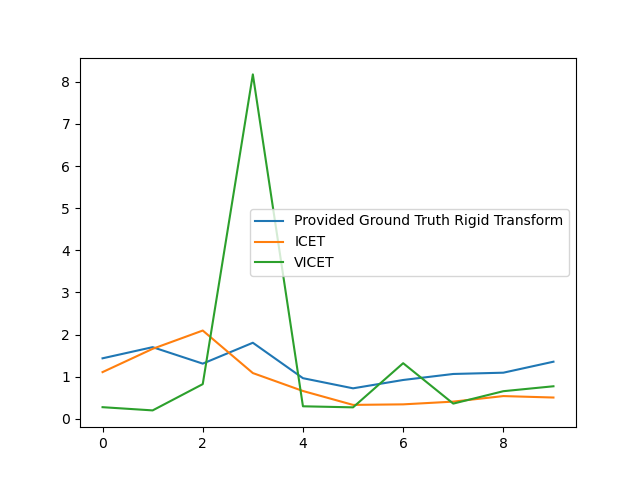

In [86]:
np.savetxt("results/raw_CD_06.txt", raw_CD_hist)
np.savetxt("results/ICET_CD_06.txt", rigid_ICET_CD_hist)
np.savetxt("results/VICET_CD_06.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

# Calculate Chamfer Distance over 1000 frame sequence in $\textit{Quad With Dynamics}$ Trajectory

In [87]:
runlen = 10 #100
start_idx = 2000 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
#     fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
        dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 20, 
                draw = False, mnp = 25, RM = False, solver = '12_state', 
                max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 25, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
    source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
    source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #need to downsample to keep runtime down
    target_cloud = torch.from_numpy(submap_lidarframe[::10,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    


 
 Frame # 2000 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [0.0822 0.1195 0.0086 0.0176 0.0135 0.0162] 
 [ 0.0331 -0.0493 -0.0567 -0.0123 -0.0104 -0.0193]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [0.1195 0.2392 0.0088 0.0174 0.0166 0.0195] 
 [ 0.0601  0.0031 -0.075  -0.014  -0.0151 -0.0237]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [0.1575 0.3185 0.0021 0.0172 0.0166 0.022 ] 
 [ 0.0892  0.0369 -0.066  -0.0119 -0.0153 -0.0219]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.2017  0.3494 -0.0056  0.0153  0.0151  0.026 ] 
 [ 0.1267  0.0446 -0.0536 -0.0026 -0.0138 -0.0223]
~~~~~~~~~~~Iterati

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.2597  0.3846 -0.1253  0.0228  0.006   0.0273] 
 [ 0.2215 -0.1079 -0.0657  0.0062 -0.0127  0.0169]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.2652  0.3906 -0.1245  0.0227  0.0065  0.0262] 
 [ 0.2257 -0.1053 -0.0693  0.0061 -0.0135  0.0197]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.2663  0.3936 -0.1251  0.0226  0.006   0.0258] 
 [ 0.2268 -0.1035 -0.0668  0.0067 -0.0126  0.0222]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.2689  0.3959 -0.1268  0.0226  0.0057  0.0255] 
 [ 0.2295 -0.1022 -0.0634  0.0068 -0.0119  0.0247]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.1857  0.3372 -0.2132  0.0301 -0.0035  0.0015] 
 [ 0.2453  0.3682 -0.1419 -0.0142 -0.0183  0.0061]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.205   0.35   -0.2175  0.0293 -0.0046  0.0015] 
 [ 0.2042  0.3615 -0.128  -0.011  -0.0164  0.0071]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.2109  0.3538 -0.2211  0.0291 -0.0055  0.002 ] 
 [ 0.1994  0.3619 -0.1185 -0.0095 -0.015   0.0067]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.2236  0.3557 -0.2281  0.0287 -0.0065  0.0027] 
 [ 0.1923  0.3609 -0.1012 -0.0073 -0.013   0.0043]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.3111  0.7392 -0.2765  0.0341 -0.0145 -0.0547] 
 [ 0.4955  0.1349 -0.0728 -0.0259 -0.0059  0.0298]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [-0.3119  0.741  -0.2728  0.0344 -0.014  -0.0547] 
 [ 0.4919  0.1269 -0.0787 -0.0278 -0.0068  0.0311]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.3088  0.7459 -0.2703  0.0341 -0.0136 -0.055 ] 
 [ 0.4927  0.1225 -0.0863 -0.0267 -0.0076  0.0308]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24

 estimated solution vector X: 
 tf.Tensor([ 0.06459267  0.8326987  -0.30117902  0.02852428 -0.01920047 -0.03585529], shape=(6,), dtype=float


 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0463  0.7532 -0.2588  0.033  -0.015  -0.0523] 
 [-0.2722  0.2215 -0.0955 -0.012  -0.0073 -0.007 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0448  0.7723 -0.263   0.033  -0.0159 -0.0531] 
 [-0.2817  0.194  -0.0868 -0.012  -0.0058 -0.0052]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0524  0.7682 -0.2654  0.0334 -0.016  -0.0513] 
 [-0.2665  0.2214 -0.0837 -0.013  -0.0057 -0.0114]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0512  0.7737 -0.2659  0.0334 -0.016  -0.0525] 
 [-0.2706  0.2094 -0.0822 -0.0124 -0.0054 -0.0096]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.054   0.772  -

iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24

 estimated solution vector X: 
 tf.Tensor([-0.1368715   0.9250124  -0.14804389  0.01924386 -0.00621732 -0.06799524], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 50134.015625
Chamfer Distance after VICET: 
: 13709.806640625
Chamfer Distance after ICET: 
: 17102.1953125

 Normalized OG CD: 
 tensor(0.8714)

 Normalized VICET CD: 
 tensor(0.2383)

 Normalized ICET CD: 
 tensor(0.2973)

 
 Frame # 2008 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.3235  0.63   -0.0046  0.0094 -0.0019 -0.0337] 
 [ 0.0326 -0.4067 -0.1065 -0.003  -0.0073 -0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.4366  0.6767 -0.0402  0.0203  0.0038 -0.0362] 
 [ 0.1454 -0.0021 -0.1031 -0.0359 -0.0117 -0.0433]
~~~~~~~~~~~Iteratio

LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.0001  0.6083 -0.0766  0.0118  0.0003 -0.0406] 
 [-0.0892  0.214  -0.0838  0.0148 -0.0158 -0.0038]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.0001  0.5982 -0.0788  0.0118  0.0001 -0.0392] 
 [-0.0792  0.2342 -0.0794  0.0153 -0.0155 -0.0077]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.0034  0.6047 -0.0762  0.0112 -0.0005 -0.0397] 
 [-0.0898  0.2215 -0.0804  0.0169 -0.0148 -0.0059]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.0027  0.598  -0.077   0.0114 -0.0003 -0.0389] 
 [-0.0793  0.2393 -0.0817  0.0162 -0.0149 -0.0086]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 resi

<IPython.core.display.Javascript object>


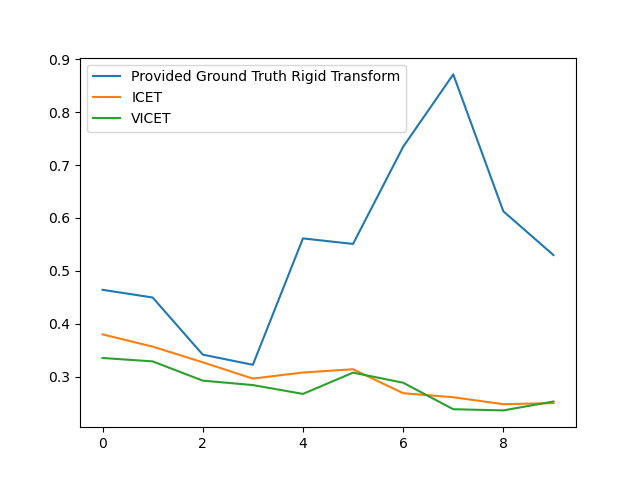

In [89]:
np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

In [95]:
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))


 ICET: 0.3008559003472328

 VICET: 0.2830726206302643


In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [ ]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

In [ ]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

# #matt's attempt:
# rot_m = R.from_quat(gt[idx,5:]).as_matrix()
# newscan_mapframe = (pc1 @ rot_m) + gt[idx,2:5]
# disp.append(Points(newscan_mapframe, c = 'blue',r = 2))

#kitware code
newscan_mapframe = (poses[idx] @ np.append(pc1, np.zeros([len(pc1),1]), axis=1).T).T
print(newscan_mapframe)
disp.append(Points(newscan_mapframe[:,:3], c = 'blue',r = 2))

#draw trajectory of platform according to <gt>
disp.append(Points(gt[2000:3000,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[idx+offset,2:5][None,:], r=10, c = 'red'))

#draw arrows showing heading
for i in range(50):
    rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
    arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
    disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)